# Caso de Prueba 03: Churn Analysis

In [93]:
#Importaciones
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold, cross_val_predict
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_auc_score, roc_curve
from sklearn.preprocessing import StandardScaler
from tqdm import tqdm
from timeit import default_timer as timer
from imblearn.over_sampling import SMOTE
import matplotlib.pyplot as plt

In [9]:
#Lectura de datos
file_path = 'EarlyRetirementPrediction.xlsx'
data = pd.read_excel(file_path)
# Renombrar las columnas para facilitar su manejo
# Renombrar las columnas para facilitar su manejo
data.columns = ['Retire_Before_65', 'Gender', 'Desease', 'Education_Level', 'Marital_Status',
                'Monthly_Income', 'Employee_Employer', 'Dependants', 'Unemployment_Rate',
                'Stock_Market', 'Credit_Score', 'Government_Bonds_Return']
data

,Retire_Before_65,Gender,Desease,Education_Level,Marital_Status,Monthly_Income,Employee_Employer,Dependants,Unemployment_Rate,Stock_Market,Credit_Score,Government_Bonds_Return
0,1,1,1,3,0,18000,0,4,3.444876,24066.16667,699,7.715833
1,0,1,0,3,0,32000,0,1,5.023797,42063.16667,639,5.414833
2,0,1,1,4,0,20000,0,2,5.355220,30100.50000,610,7.962750
3,0,0,1,4,1,35000,1,1,3.843570,24066.16667,649,7.715833
4,0,0,1,3,0,27000,0,1,4.949226,19439.00000,638,8.024167
...,...,...,...,...,...,...,...,...,...,...,...,...
1495,1,0,0,5,1,26000,0,2,5.111358,32304.66667,604,7.193917
1496,0,1,0,3,0,32000,0,4,4.929185,41229.83333,753,5.910000
1497,1,1,1,4,1,17000,0,2,5.054852,37846.16667,631,6.198750
1498,0,0,0,5,0,26000,0,2,4.827790,41229.83333,613,5.910000


In [10]:
# Separar las características (X) y la variable objetivo (y)
X = data.drop('Retire_Before_65', axis=1)
y = data['Retire_Before_65']

In [11]:
# Normalizar las características
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [60]:
# Manejo del desbalance de clases con SMOTE
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_scaled, y)

In [75]:
# Dividir los datos en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.3, stratify=y_resampled)

# Configuración de la validación cruzada estratificada
cv = StratifiedKFold(n_splits=5, shuffle=True)

# Configuración del grid search para ajustar los hiperparámetros
param_grid = {
    'C': [0.01, 0.1, 1, 10, 100],
    'penalty': ['l1', 'l2'],
    'solver': ['liblinear']
}

grid_search = GridSearchCV(LogisticRegression(max_iter=10000), param_grid, cv=cv, scoring='roc_auc', n_jobs=-1)

# Entrenar el modelo
grid_search.fit(X_train, y_train)

# Evaluar el mejor modelo
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)
y_pred_proba = best_model.predict_proba(X_test)[:, 1]

# Reportar los resultados
print("Best Hyperparameters:", grid_search.best_params_)
print(classification_report(y_test, y_pred))
print("ROC AUC Score:", roc_auc_score(y_test, y_pred_proba))

# Evaluar el modelo
accuracy = accuracy_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)

print("Accuracy:", accuracy)
print("Confusion Matrix:\n", conf_matrix)

Best Hyperparameters: {'C': 0.01, 'penalty': 'l2', 'solver': 'liblinear'}
              precision    recall  f1-score   support

           0       0.86      0.84      0.85       238
           1       0.84      0.86      0.85       239

    accuracy                           0.85       477
   macro avg       0.85      0.85      0.85       477
weighted avg       0.85      0.85      0.85       477

ROC AUC Score: 0.8850075595091593
Accuracy: 0.8511530398322851
Confusion Matrix:
 [[200  38]
 [ 33 206]]


In [77]:
y_train.value_counts()

Retire_Before_65
0    556
1    555
Name: count, dtype: int64

In [98]:
entrenamiento = pd.DataFrame(scaler.inverse_transform(X_train))
entrenamiento.columns = ['Gender', 'Desease', 'Education_Level', 'Marital_Status',
                'Monthly_Income', 'Employee_Employer', 'Dependants', 'Unemployment_Rate',
                'Stock_Market', 'Credit_Score', 'Government_Bonds_Return']
entrenamiento['Retire_Before_65'] = y_train.values

In [100]:
entrenamiento['Gender'] = entrenamiento['Gender'].round()
entrenamiento['Desease'] = entrenamiento['Desease'].round()
entrenamiento['Education_Level'] = entrenamiento['Education_Level'].round()
entrenamiento['Marital_Status'] = entrenamiento['Marital_Status'].round()
entrenamiento['Monthly_Income'] = entrenamiento['Monthly_Income'].round()
entrenamiento['Employee_Employer'] = entrenamiento['Employee_Employer'].round()
entrenamiento['Dependants'] = entrenamiento['Dependants'].round()

In [101]:
entrenamiento['Gender'] = entrenamiento['Gender'].replace({0: 'Femenino', 1: 'Masculino'})
entrenamiento['Desease'] = entrenamiento['Desease'].replace({0: 'Con enfermedad', 1: 'Sin enfermedad'})
entrenamiento['Education_Level'] = entrenamiento['Education_Level'].replace({1: 'Elemental o sin estudios', 2: 'Básica', 3: 'Media', 4: 'Superior', 5: 'Posgrado'})
entrenamiento['Marital_Status'] = entrenamiento['Marital_Status'].replace({1: 'Casado', 0: 'Soltero'})
entrenamiento['Employee_Employer'] = entrenamiento['Employee_Employer'].replace({1: 'Empleador', 0: 'Empleado'})
entrenamiento['Retire_Before_65'] = entrenamiento['Retire_Before_65'].replace({1: 'Antes de los 65', 0: '65 o después'})

In [102]:
entrenamiento.to_csv("Retiro Entrenamiento con etiquetas.csv", index=False)

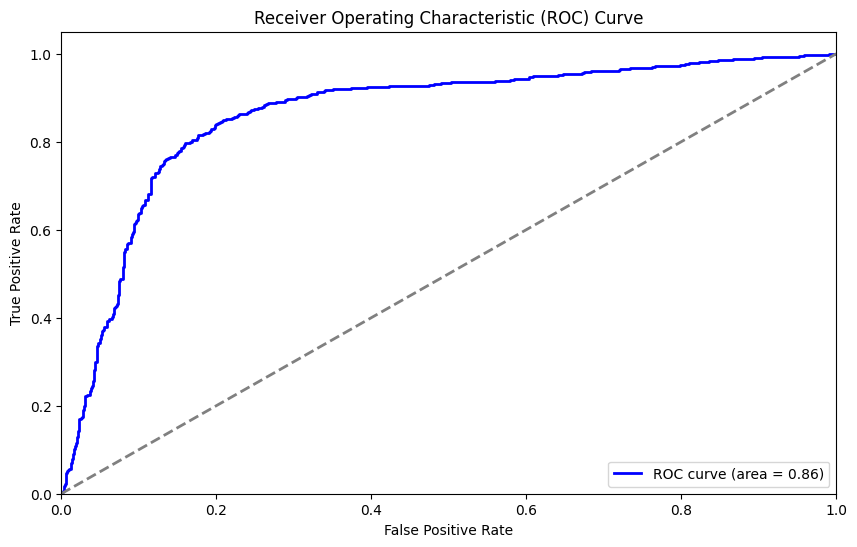

In [94]:
y_pred_proba = cross_val_predict(best_model, X_scaled, y, cv=cv, method='predict_proba')[:, 1]

# Calcular la curva ROC
fpr, tpr, thresholds = roc_curve(y, y_pred_proba)
roc_auc = roc_auc_score(y, y_pred_proba)

# Graficar la curva ROC
plt.figure(figsize=(10, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

In [95]:
conf_matrix

array([[200,  38],
       [ 33, 206]], dtype=int64)

In [109]:
y_pred_proba = cross_val_predict(best_model, X_test, y_test, cv=cv, method='predict_proba')[:, 1]


In [110]:
prediccion = pd.DataFrame({'real': y_test, 'prediccion': y_pred_proba})

In [111]:
prediccion.to_csv("probabilidades.csv", index=False)

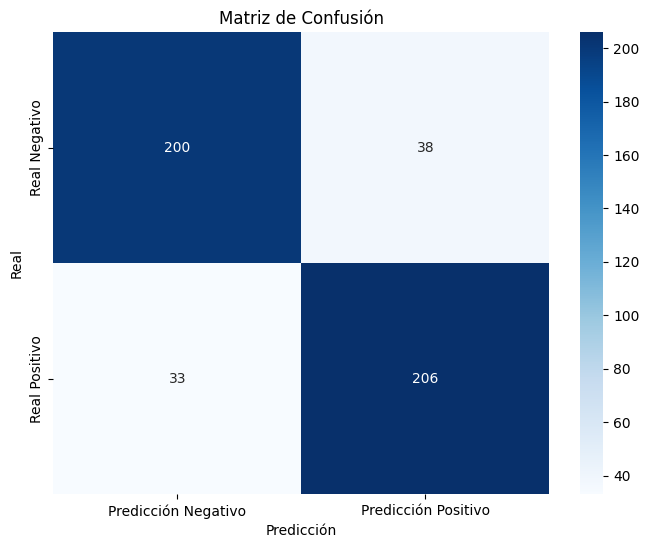

In [112]:
# Importar librerías necesarias
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Cargar los datos seleccionados en Power BI
# Supongamos que tus columnas se llaman 'real' y 'prediccion'

# Calcular la matriz de confusión
cm = confusion_matrix(y_test, y_pred)

# Crear un DataFrame a partir de la matriz de confusión
cm_df = pd.DataFrame(cm, index=['Real Negativo', 'Real Positivo'], columns=['Predicción Negativo', 'Predicción Positivo'])

# Crear la gráfica de la matriz de confusión
plt.figure(figsize=(8, 6))
sns.heatmap(cm_df, annot=True, fmt='d', cmap='Blues')
plt.title('Matriz de Confusión')
plt.ylabel('Real')
plt.xlabel('Predicción')
plt.show()
